In [97]:
from ase.calculators.lj import LennardJones
from ase.calculators.plumed import Plumed
from ase.constraints import FixedPlane
from ase.md.langevin import Langevin
from ase.io import read
from ase import units

In [98]:
# Tutorial from https://gitlab.com/Sucerquia/ase-plumed_tutorial
timestep = 0.005
ps = 1000 * units.fs 

setup = [f"UNITS LENGTH=A TIME={1/ps} ENERGY={units.mol/units.kJ}",
         "c1: COORDINATIONNUMBER SPECIES=1-7 MOMENTS=2-3" +
         " SWITCH={RATIONAL R_0=1.5 NN=8 MM=16}",
         "PRINT ARG=c1.* STRIDE=10 FILE=COLVAR",
         "FLUSH STRIDE=100"]


In [99]:
from ase.calculators.lj import LennardJones
from ase.calculators.plumed import Plumed
from ase.constraints import FixedPlane
from ase.md.langevin import Langevin
from ase.io import read
from ase import units


timestep = 0.005

ps = 1000 * units.fs
setup = [f"UNITS LENGTH=A TIME={1/ps} ENERGY={units.mol/units.kJ}",
         "c1: COORDINATIONNUMBER SPECIES=1-7 MOMENTS=2-3" +
         " SWITCH={RATIONAL R_0=1.5 NN=8 MM=16}",
         "PRINT ARG=c1.* STRIDE=100 FILE=COLVAR",
         "FLUSH STRIDE=1000"]

atoms = read('../resources/isomerLJ.xyz')
# Constraint to keep the system in a plane
cons = [FixedPlane(i, [0, 0, 1]) for i in range(7)]
atoms.set_constraint(cons)
atoms.set_masses([1, 1, 1, 1, 1, 1, 1])

atoms.calc = Plumed(calc=LennardJones(rc=2.5, r0=3.),
                    input=setup,
                    timestep=timestep,
                    atoms=atoms,
                    kT=0.1)

dyn = Langevin(atoms, timestep, temperature_K=0.1/units.kB, friction=1,
               fixcm=False, trajectory='UnbiasMD.traj')

dyn.run(1000)

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/amritagos/micromamba/envs/plumedenv/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.9.2 (git: Unknown) compiled on Sep  4 2024 at 12:23:39
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/amritagos/micromamba/envs/plumedenv/lib/plumed
PLUMED: For installed feature, see /home/amritagos/micromamba/envs/plumedenv/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: ASE
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 7
PLUMED: File suffix: 
PLUMED: Timestep: 0.000051
PLUMED: KbT: 9.648533
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished setup
PLUMED: Action UNITS
PLUMED:   with label @0
PLUMED:   leng

True

In [100]:
import numpy as np 

def coordination_numbers(atoms, d=1.5):
    cn = np.zeros(len(atoms))
    for i,atom_i in enumerate(atoms):
        cn[i] = 0
        for atom_j in atoms:
            if atom_i.index==atom_j.index:
                continue
            r_ij = atoms.get_distance(atom_i.index, atom_j.index, mic=False)
            cn[i] += (1-(r_ij/d)**8)/(1-(r_ij/d)**16)
    return cn

def moment(atoms, order, coordination_numbers):
    n_atoms = len(atoms)
    coord_num_exp = np.mean(coordination_numbers)
    moment = 0.0

    for i in range(n_atoms):
        moment += (coordination_numbers[i] - coord_num_exp)**order
    return moment/n_atoms

coord_num_val = coordination_numbers(atoms)
scm = moment(atoms, 2, coord_num_val)
tcm = moment(atoms, 3, coord_num_val)
print(f"{scm=}")
print(f"{tcm=}")

scm=0.7372814604970135
tcm=1.2630076455198833


PLUMED:                                               Cycles        Total      Average      Minimum      Maximum
PLUMED:                                                    1     0.007462     0.007462     0.007462     0.007462
PLUMED: 1 Prepare dependencies                          1001     0.000537     0.000001     0.000000     0.000008
PLUMED: 2 Sharing data                                    11     0.000079     0.000007     0.000006     0.000009
PLUMED: 3 Waiting for data                                11     0.000008     0.000001     0.000000     0.000001
PLUMED: 4 Calculating (forward loop)                      11     0.000319     0.000029     0.000024     0.000037
PLUMED: 5 Applying (backward loop)                        11     0.000023     0.000002     0.000002     0.000003
PLUMED: 6 Update                                          11     0.000167     0.000015     0.000008     0.000059


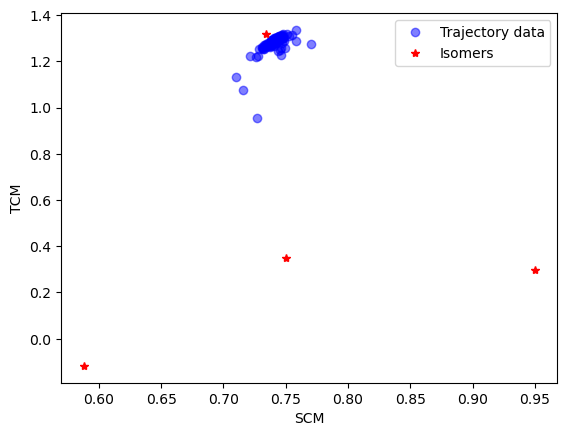

In [101]:
import matplotlib.pyplot as plt

# Isomer scm and tcm values 
# from ASE_PLUMED tutorial (https://github.com/Sucerquia/ASE-PLUMED_tutorial)
isomers_scm = [0.588, 0.734, 0.75, 0.95]
isomers_tcm = [-0.118, 1.318, 0.348, 0.297]

data = np.loadtxt("COLVAR", skiprows=1)
scm = data[:, 1]
tcm = data[:, 2]

fig, ax = plt.subplots()

ax.plot(scm, tcm, "o", color="blue", alpha=0.5, label="Trajectory data") # MD trajectory data
ax.plot(isomers_scm, isomers_tcm, "*", color="red", label="Isomers")
ax.legend()
ax.set_xlabel("SCM")
ax.set_ylabel("TCM")
plt.show()